In [1]:
# Full repository, etl pipelines, and architecture that I used to create the initial csv: 
# https://github.com/x-ruiz/project-formula-1-wc-analytics
import pandas as pd
import dataframe_image as dfi
from IPython.display import Image, display
from concurrent.futures import ThreadPoolExecutor
from varname import varname

In [2]:
# Set Global Variables
gcp_project = "formula-1-wc-analytics"
# Function to export image in a separate thread
def export_df_image(dataframe, filename):
    dfi.export(dataframe, filename)

In [3]:
# EXTRACT | Prepped enriched csv from GCP BigQuery I created
def extract(filepath: str) -> pd.DataFrame:
    return pd.read_csv(filepath)

In [4]:
# CLEAN|Clean data type from string to bool and drop unnecessary columns
def clean(df: pd.DataFrame) -> pd.DataFrame:
    df_cleaned = df.drop(columns=['url', 'date', 'grand_prix', 'circuit_ref', 'circuit_name'])
    df_cleaned['won_home_race'] = df['won_home_race'].astype(bool)
    return df_cleaned

In [5]:
# TRANSFORM | Common Aggregations This is a general function that will perform some of the common aggregations we want to perform
# Deep copying in order to be able to reuse cleaned data for multiple transformations
def transform(df: pd.DataFrame, by_value: list[str], include_driver: bool) -> pd.DataFrame:
    # identify the average home wins per driver per grand prix
    df_agg = df.copy(deep=True).groupby(by_value).agg(
        num_races = ('race_id', 'count'),
        num_unique_winners = ('winner_driver', 'nunique'),
        num_home_wins = ('won_home_race', 'sum'), # We can use sum here because dtype=bool
        num_unique_home_winners = ('winner_driver', lambda x: (x[df.loc[x.index, 'won_home_race']].nunique())))
    if include_driver:
        df_agg['avg_home_win_per_driver'] = round(df_agg['num_home_wins'] / df_agg['num_unique_home_winners'], 2)
        # identify # of home wins by driver
        df_agg_driver = df.copy(deep=True)
        df_agg_driver = df_agg_driver.groupby(['winner_driver', by_value[0]]).agg( # winner_driver and country are now part of Multiindex
            num_home_wins = ('won_home_race', 'sum'),
        ).groupby(by_value).agg(
            max_driver_home_wins = ('num_home_wins', 'max'),
            top_driver = ('num_home_wins', lambda x: 'none' if x.max() == 0 else x.idxmax()[0])
        ).sort_values(by='max_driver_home_wins', ascending=False)
        # Join the two aggregated dfs
        df_joined = pd.merge(df_agg, df_agg_driver, left_on=by_value, right_on=by_value, how='inner')
        return df_joined
    else:
        return df_agg
def rank(df: pd.DataFrame, parsed_column: str, new_column: str):
    df[new_column] = df[parsed_column].rank(na_option='bottom', ascending=False, method='dense').astype(int)

Exported: df_extracted
Exported: df_cleaned
Exported: df_country_transformed
Exported: df_both_transformed


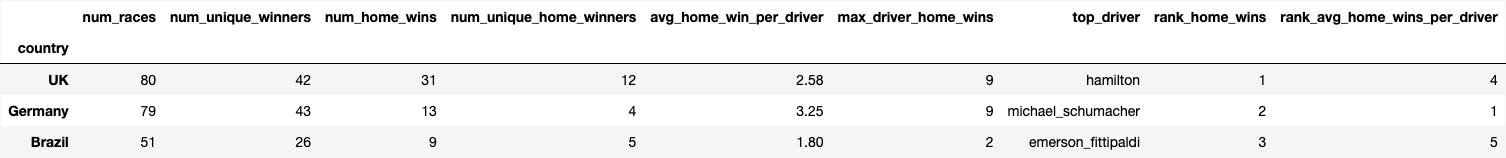

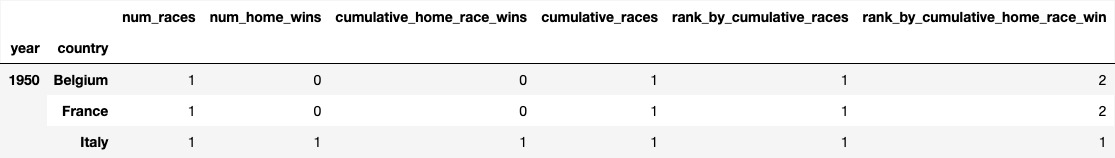

In [7]:
# PIPELINE | Execute functions in ETL fashion and output dfs as images
df = extract("f1_data_enriched.csv")
df_cleaned = clean(df)
# First transformation dataset grouped by country
df_country_transformed = transform(df_cleaned, ['country'], True).sort_values(by="num_home_wins", ascending=False)
rank(df_country_transformed, 'num_home_wins', 'rank_home_wins') # modifies original transformed df
rank(df_country_transformed, 'avg_home_win_per_driver', 'rank_avg_home_wins_per_driver') # modifies original transformed df
# Second transformation dataset grouped by year and country
df_both_transformed = (transform(df_cleaned,['year', 'country'],False)
    .drop(columns=['num_unique_home_winners', 'num_unique_winners'])
    .sort_values(by=['year', 'country'], ascending=True)
    .assign(
        cumulative_home_race_wins = lambda x: x.groupby('country')['num_home_wins'].cumsum(),
        cumulative_races = lambda x: x.groupby('country')['num_races'].cumsum())
    .assign(
         # Doing a transform not agg because we want results 1:1 with each row
        rank_by_cumulative_races = lambda x: x.groupby('year')['cumulative_races'].transform(
                lambda x: x.rank(na_option='bottom', ascending=False, method='dense').astype(int)),
        rank_by_cumulative_home_race_win = lambda x: x.groupby('year')['cumulative_home_race_wins'].transform(
                lambda x: x.rank(na_option='bottom', ascending=False, method='dense').astype(int)))
)
# exporting all our dataframes as csvs and images for documentation on github
# We are threading here since dataframe_image is an async process
outputs = [(df, "df_extracted"), (df_cleaned, "df_cleaned"), (df_country_transformed, "df_country_transformed"), 
           (df_both_transformed, "df_both_transformed")]
with ThreadPoolExecutor() as executor: # handles enter and exit
    for i in outputs:
        future_df = executor.submit(export_df_image, i[0].head(3), f"images/{i[1]}.png")
        future_df.result() # Wait for the export to complete
        i[0].to_csv(f'outputs/f1_{i[1]}_output.csv')
        print(f"Exported: {i[1]}")
display(Image(f'images/df_country_transformed.png'))
display(Image(f'images/df_both_transformed.png'))

In [8]:
# ANALYZE | Determining some information from transformed datasets
home_wins_by_country = df_country_transformed['rank_home_wins']
avg_home_wins_by_country = df_country_transformed['rank_avg_home_wins_per_driver'].sort_values(ascending=True)
combined_df = pd.concat([home_wins_by_country.rename("Home Wins"), avg_home_wins_by_country.rename("Avg Home Wins per Driver")], axis=1)
print(f"Comparison of Home Wins and Avg Home Wins per Driver:\n {combined_df.head(5)}")

Comparison of Home Wins and Avg Home Wins per Driver:
          Home Wins  Avg Home Wins per Driver
country                                     
UK               1                         4
Germany          2                         1
Brazil           3                         5
France           4                         3
Italy            5                         6


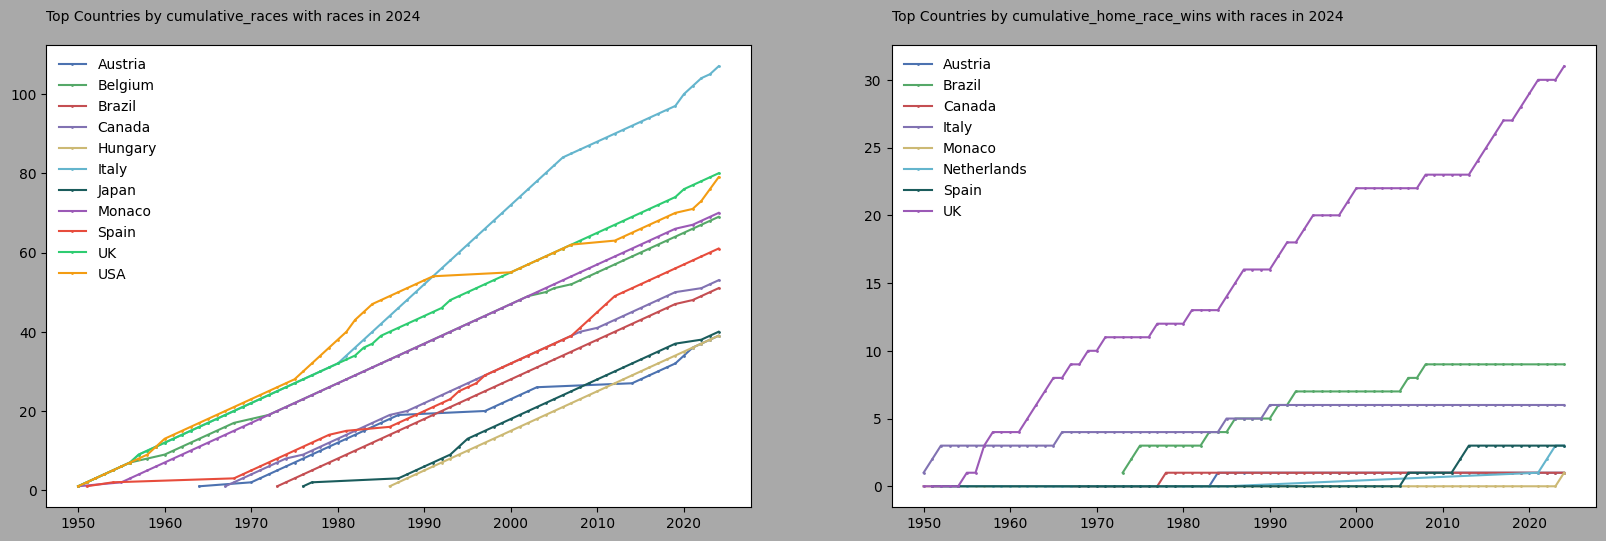

In [14]:
# VISUALIZE | Countries ranked by # of cumulative home wins vs Countries ranked by # of cumulative races
import matplotlib.pyplot as plt
import seaborn as sns
# Plot colors
colors = ['#4C72B0','#55A868','#C44E52','#8172B2','#CCB974','#64B5CD', '#1A5C5C','#9B59B6','#E74C3C','#2ECC71','#F39C12']
def plot_num_races(axes: plt.axes, position: int, year: int = 2024, top_n: int = 10, column: str = "", rank_column: str = ""):
    """
    This function creates a time series plot with the x axis being years 1950-2024, and y axis being a specified column
    Parameters:
        year (str): the year to snapshot at
        top_n (int): the number to look at at the specified year (ex: top 10 countries by column)
        column (str): the column to compare year over year
        rank_column (str): the rank column to snapshot combined with year that ranks the column
    """
    # Masks to visualize properly, not transformations
    # Get top n countries by cumulative races snapshot at year
    tmp_df = df_both_transformed.reset_index()
    year_ts = tmp_df[tmp_df['year'] == year]
    top_n = year_ts[year_ts[rank_column] <= top_n]
    top_n_countries = list(top_n['country'])

    # ax.set_facecolor('darkgrey')
    axes[position].set_title(f'Top Countries by {column} with races in {year}\n', loc='left', fontsize=10)
    # plot the country data over all years 1950-2024
    for i, v in enumerate(top_n_countries):
        temp = tmp_df[tmp_df['country'] == v] # mask to restrict to subset of country
        axes[position].plot(temp.year, temp[column], color=colors[i], marker='o', markersize=1) 
    axes[position].legend(top_n_countries, loc='upper left', frameon=False)
    
fig, ax = plt.subplots(1, 2, figsize=(20,6), facecolor='darkgrey')
plot_num_races(ax, 0, 2024, 10, "cumulative_races", "rank_by_cumulative_races")
plot_num_races(ax, 1, 2024, 5, "cumulative_home_race_wins", "rank_by_cumulative_home_race_win")
plt.show()